In [1]:
from IPython.core.display import display, HTML

from DataProcessing import *
from FeatureEngineering import *
from ModelManager import *

#### Instantiate data object *data*  and assign train and test sets

In [2]:
ordinalcodes = {'degree':{'NONE':0,
                          'HIGH_SCHOOL':1,
                          'BACHELORS':2,
                          'MASTERS':3,
                          'DOCTORAL':4},
               'jobType':{'JANITOR':0,
                          'JUNIOR':1,
                          'SENIOR':2,
                          'MANAGER':3,
                          'VICE_PRESIDENT':4,
                          'CFO':5,
                          'CTO':6,
                          'CEO':7}
               }


data = Data('train_features.csv','train_salaries.csv',
         ['companyId','degree','industry','jobType','major'],
         ['milesFromMetropolis','yearsExperience'],
         'salary','jobId',ordinalcodes,test_sz=.3)


# drop zero-valued response rows and encode categorical 
# features to numeric for train and test sets 
train_df = data._preprocessData(data.train_df,True,True,
                                ['companyId','industry','major'])
test_df = data._preprocessData(data.test_df,True,True,
                               ['companyId','industry','major'])

# assign original-state vectorized dataset 
vec_train_df = train_df.copy()

train_df.shape,test_df.shape

((699996, 9), (299999, 9))

#### Instantiate feature engineering object *featureEng* and generate grouped categorical and numeric feature response statistics as new features   

In [3]:
featureEng = FeatureEng(data) 

train_df = featureEng._compute_new_features(vec_train_df,
                                            train_df,
                                            featureEng.data.columns_cat,
                                            featureEng.data.columns_num,4)
test_df = featureEng._compute_new_features(vec_train_df,
                                           test_df,
                                           featureEng.data.columns_cat,
                                           featureEng.data.columns_num,4)

# drop response,id columns from train and id column from train and test sets
Xtrain_df = train_df.drop([data.ylabel,data.id],axis=1)
ytrain_df = train_df[data.ylabel]

Xtest_df = test_df.drop([data.ylabel,data.id],axis=1)
ytest_df = test_df[data.ylabel]

display(Xtrain_df.head())
Xtrain_df.shape,Xtest_df.shape

,milesFromMetropolis,yearsExperience,companyId,industry,major,degree,jobType,cat_group_min,cat_group_median,cat_group_mean,cat_group_max,cat_group_std,milesFromMetropolis_quantile,yearsExperience_quantile,numeric_quantile_min,numeric_quantile_median,numeric_quantile_mean,numeric_quantile_max,numeric_quantile_std
0,48,13,24,2,7,0,3,64,114.5,119.703704,175,27.743182,1,2,41,130,131.519088,271,41.808072
1,39,0,32,6,7,1,0,37,69.0,72.815217,135,22.267568,1,0,24,102,103.235091,245,39.299300
2,5,22,24,5,2,2,3,91,121.0,129.428571,184,31.889691,0,3,63,158,160.099339,301,44.192311
3,95,12,54,6,3,4,3,107,115.0,132.200000,184,32.949962,3,1,24,99,100.499388,235,38.907928
4,50,9,17,1,6,3,3,81,107.0,106.714286,140,19.972600,1,1,34,116,117.893298,260,40.277559


((699996, 19), (299999, 19))

In [4]:
class ModelManager:
    '''
    manage estimator predictions and loss, 
    feature importances 
    '''
    def __init__(self,data_object,model_list,
                 loss_dict,folds,best_estimator=None,
                 yhat_test=None):
        self.data = data_object
        self.estimator_list = model_list
        self.loss_dict = loss_dict
        self.folds = folds
        self.best_estimator = best_estimator
        self.yhat_test = yhat_test

    def _add_estimator(self,estimator):
        '''
        add linear estimator to self.model_list
        '''
        self.estimator_list.append(estimator)
    
    
    def _cross_validate_estimator(self,estimator,
                                  Xtrain,ytrain):
        '''
        train, cross validate linear estimator and assign 
        loss metrics to self.loss_dict and obtain best estimator 
        '''
        # compute k-fold cross-validated neg_mse
        scores_array = cross_val_score(estimator,
                                      Xtrain,ytrain,
                                      scoring='neg_mean_squared_error',
                                      cv=self.folds)
        #mse 
        cv_mse_mean = np.nanmean(-1.0*scores_array)
        cv_mse_std = np.std(scores_array)
        # rmse
        scores_array_rmse = np.sqrt(-1.0*scores_array)
        cv_rmse_mean = np.nanmean(-1.0*scores_array_rmse)
        cv_rmse_std = np.std(scores_array_rmse)
        # assign average cv train MSE value to corresponding loss_dict key
        self.loss_dict[estimator] = cv_mse_mean
        
    def _select_best_estimator(self):
        '''
        assign best_estimator as estimator with minimal MSE 
        value in self.loss_dict
        '''
        best_estimator = min(self.loss_dict,
                             key=self.loss_dict.get)
        return best_estimator

    
    def _fit_best_estimator(self,Xtrain,ytrain):
        '''
        fit best estimator from _cross_validate_estimator 
        '''
        return self.best_estimator.fit(Xtrain,ytrain)
        

    def _best_estimator_test_predict(self,X_test,y_test):
        '''
        generate best estimator prediction self.yhat_test 
        from _cross_validate_estimator
        X_test    : pre-vectorized test data set features, DataFrame
        y_test    : test data set response, DataFrame 
        returns   : None 
        '''
        self.yhat_test = self.best_estimator.predict(X_test)
        error_vec = y_test - self.yhat_test
        mse = np.mean(np.square(error_vec))
        print('test MSE:',mse)
        print('-'*70)

    
    def _compute_feature_importances(self,Xtrain,
                                     figsz=(12,6),xrotate=45):
        '''
        return feature_importance attribute from 
        estimator, when available
        '''
        print('Feature Importance Summary:')
        best_estimator = self.best_estimator.steps[1][1]
        if hasattr(best_estimator,'feature_importances_'):
            f_importances = best_estimator.feature_importances_
            importances_df = pd.DataFrame({'feature':Xtrain.columns,
                                           'importance':f_importances})
            importances_df.set_index('feature',inplace=True,
                                     drop=True)
            importances_df.sort_values(by='importance',
                                       ascending=False,
                                       inplace=True)
            display(importances_df)
            importances_df.plot(kind='bar',figsize=figsz,rot=xrotate)
        else:
            print('self.best_estmimator does not have attribute feature_importances_')
        
    def _summarize_estimators(self):
        print('Linear Estimator Cross-Validated Loss Summary:')
        for est in self.loss_dict:
            print('\n{}'.format(est.steps[1][1]))
            print('{}-fold CV MSE: {}'.format(self.folds,
                                              self.loss_dict[est]))
            
        # show best estimator
        self.best_estimator = self._select_best_estimator()
        print('\n')
        print('-'*70)
        print('Best estimator:\n{}'.format(self.best_estimator.steps[1][1]))
        print('-'*70)


#### Assign ModelManager global parameters

In [5]:
loss_container = {}
estimatorList = []

#### Instantiate pre-tuned linear estimators
- *let LinearRegression* be a baseline model


In [6]:
reg_pipe = make_pipeline(SimpleImputer(strategy='median'),
                         LinearRegression()
                        )


rf_pipe = make_pipeline(SimpleImputer(strategy='median'),
                        RandomForestRegressor(
                                             n_estimators=41,
                                             max_depth=58,
                                             min_samples_split=13,
                                             min_samples_leaf=92,
                                             max_features=19,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.01716494628293873
                                             )
                       )


gb_pipe = make_pipeline(SimpleImputer(strategy='median'),
                        GradientBoostingRegressor(
                                                  learning_rate=0.13485569045908746,
                                                  n_estimators=268,
                                                  subsample=0.6886522918443929,
                                                  min_samples_split=72,
                                                  min_samples_leaf=411,
                                                  min_weight_fraction_leaf=0.04833077900157417,
                                                  max_depth=544,
                                                  min_impurity_decrease=0.00354711044501207,
                                                  max_features=8,
                                                  max_leaf_nodes=17
                                                 )
                       )

#### Determine cross-validated estimators, summarize results, display best estimator results 

Linear Estimator Cross-Validated Loss Summary:

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
5-fold CV MSE: 335.33566268313905

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=58,
           max_features=19, max_leaf_nodes=None,
           min_impurity_decrease=0.01716494628293873,
           min_impurity_split=None, min_samples_leaf=92,
           min_samples_split=13, min_weight_fraction_leaf=0.0,
           n_estimators=41, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
5-fold CV MSE: 305.77905428115827

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.13485569045908746, loss='ls', max_depth=544,
             max_features=8, max_leaf_nodes=17,
             min_impurity_decrease=0.00354711044501207,
             min_impurity_split=None, min_samples_leaf=411,
             min_samples_split=72,
             min_weight_fraction_leaf

,importance
feature,
cat_group_mean,0.377867
cat_group_median,0.234664
numeric_quantile_mean,0.117528
cat_group_min,0.087438
numeric_quantile_min,0.045637
numeric_quantile_max,0.029039
numeric_quantile_std,0.023235
numeric_quantile_median,0.018438
cat_group_std,0.016183


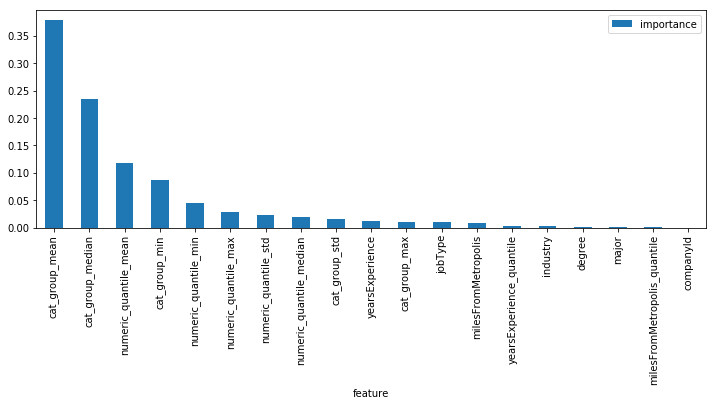

In [7]:
model_mgr = ModelManager(data_object=data,
                         model_list=estimatorList,
                         loss_dict=loss_container,folds=5,
                         best_estimator=None,yhat_test=None)   

model_mgr._add_estimator(reg_pipe)
model_mgr._add_estimator(rf_pipe)
model_mgr._add_estimator(gb_pipe)

for estimator in model_mgr.estimator_list:
    model_mgr._cross_validate_estimator(estimator=estimator,
                                        Xtrain=Xtrain_df,
                                        ytrain=ytrain_df)
    
model_mgr._summarize_estimators()

model_mgr.best_estimator = model_mgr._select_best_estimator()

model_mgr._fit_best_estimator(Xtrain=Xtrain_df,
                              ytrain=ytrain_df)

model_mgr._best_estimator_test_predict(Xtest_df,ytest_df)

model_mgr._compute_feature_importances(Xtrain=Xtrain_df,
                                       figsz=(12,4),xrotate=90)  
